In [1]:
import pyclesperanto_prototype as cle
import stackview
from napari_workflows import Workflow
from napari_workflows._io_yaml_v1 import save_workflow

from napari_ndev import morphology, nImage


In [2]:
wf = Workflow()

# label nuclei
wf.set('nuclei-labels', cle.voronoi_otsu_labeling, 'nuclei', spot_sigma=5, outline_sigma=1)
# voronoi diagram
wf.set('nuclei-voronoi', cle.extend_labeling_via_voronoi, 'nuclei-labels')

# label nucleoli
wf.set('nucleoli-med', cle.median_sphere, 'nucleoli', radius_x=1, radius_y=1)
wf.set('nucleoli-th', cle.top_hat_sphere, 'nucleoli-med', radius_x=5, radius_y=5)
wf.set('nucleoli-labels', cle.voronoi_otsu_labeling, 'nucleoli-th', spot_sigma=1, outline_sigma=1)

# label cytoplasm
wf.set('cyto-med', cle.median_sphere, 'cyto-membrane', radius_x=1, radius_y=1)
wf.set('cyto-thresh', cle.greater_constant, 'cyto-med', constant=200)
wf.set('cyto-no-nuclei', cle.logical_xor, 'cyto-thresh', 'nuclei-labels')

# voronoi, full cells
wf.set('cell-labels-float', cle.multiply_images, 'nuclei-voronoi', 'cyto-thresh')
wf.set('cell-labels', morphology.convert_float_to_int, 'cell-labels-float')

# voronoi, only with cytoplasm
wf.set('cyto-labels-float', cle.multiply_images, 'nuclei-voronoi', 'cyto-no-nuclei')
wf.set('cyto-labels', morphology.convert_float_to_int, 'cyto-labels-float')

save_workflow('scripted_cellpainting_workflow.yaml', wf)


In [3]:
img = nImage(r'ConcatenatedImages/plate1_A14_site1_Ch1.tiff')

nuclei = img.get_image_data('TCZYX', C=0).squeeze()
cyto_membrane = img.get_image_data('TCZYX', C=3).squeeze()
nucleoli = img.get_image_data('TCZYX', C=2).squeeze()

wf.set('nuclei', nuclei)
wf.set('cyto-membrane', cyto_membrane)
wf.set('nucleoli', nucleoli)

'nuclei-labels'

dtype('uint32')

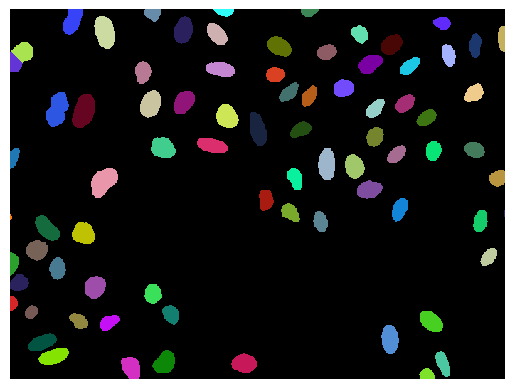

'nuclei-voronoi'

dtype('uint32')

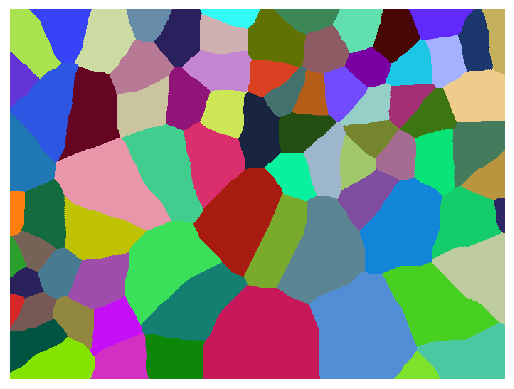

'nucleoli-labels'

dtype('uint32')

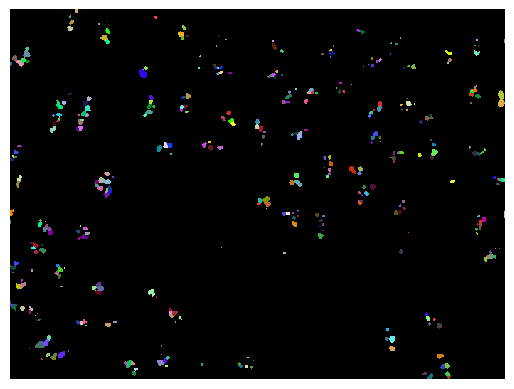

'cell-labels'

dtype('uint32')

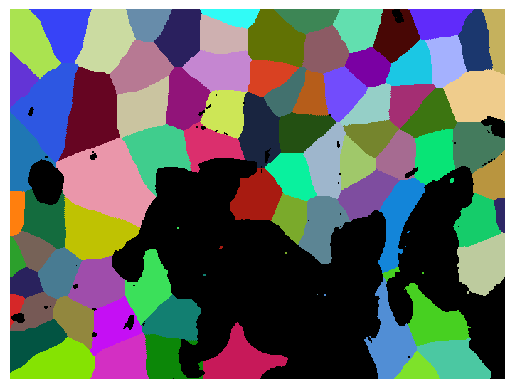

'cyto-labels'

dtype('uint32')

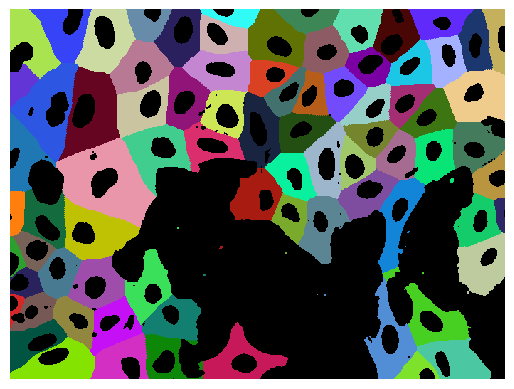

In [4]:
tasks = [
    'nuclei-labels',
    'nuclei-voronoi',
    'nucleoli-labels',
    'cell-labels',
    'cyto-labels',
]

for task in tasks:
    display(task)
    label_image = wf.get(task)
    display(label_image.dtype)
    stackview.imshow(label_image, labels=True)

cl.OCLArray([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint32)
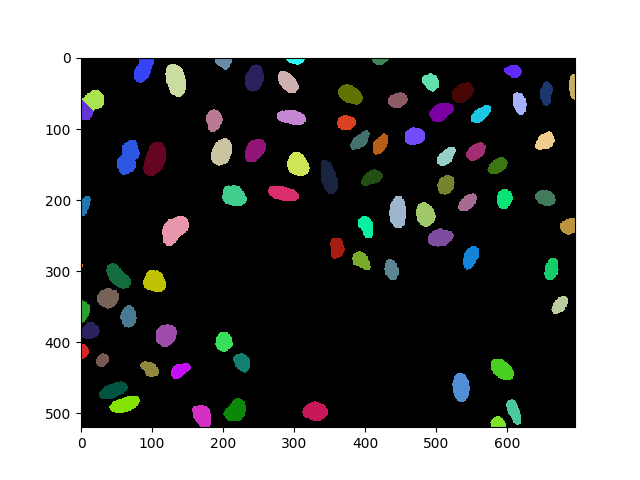

In [5]:
wf.get('nuclei-labels')